In [ ]:
"""
데이터셋
Crema, Ravdess, Tess, Savee

Positive: happiness - 2323
Neutral: neutral, calmness - 1895
Negative: anger, sadness - 3846
"""

In [1]:
import numpy as np
import time
from tqdm import tqdm
import os
import librosa
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from keras.utils.np_utils import to_categorical
from keras.models import load_model, Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, BatchNormalization, Dense, Dropout

C:\Users\DeepLearning_5\Anaconda3\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.24.3) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
base_dir = 'dataset'

n_mfcc = 128
num_features = 153
feature_shape = (num_features, )

n_epochs = 150
batch_size = None
split_val = True

model_save_path = 'saved_models/model.h5'

In [3]:
def load_feature_tuple(file_name):
    y, sr = librosa.load(file_name, mono=True)

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    spectral_flatness = librosa.feature.spectral_flatness(y=y)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y)
    
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    
    rms = librosa.feature.rms(y=y)
    
    
    image = []
    
    for row in mfcc:
        image.append(np.mean(row))
    
    image.append(np.mean(spectral_centroid))
    image.append(np.mean(spectral_bandwidth))
    for row in spectral_contrast:
        image.append(np.mean(row))
    image.append(np.mean(spectral_flatness))
    image.append(np.mean(spectral_rolloff))
    
    image.append(np.mean(zero_crossing_rate))
    for row in chroma_stft:
        image.append(np.mean(row))
    image.append(np.mean(rms))
    
    return np.array(image)

In [4]:
def extract_feature(file_name):
    return load_feature_tuple(file_name)

In [5]:
def fetch_dataset(dir_path, label):
    _features = np.empty((0, ) + feature_shape)
    for file_name in tqdm(os.listdir(dir_path)):
        file_path = os.path.join(dir_path, file_name)
        feature = extract_feature(file_path).reshape((1, ) + feature_shape)
        _features = np.append(_features, feature, axis=0)

    _labels = np.full((_features.shape[0], ), label)

    return _features, _labels

# 데이터셋 가져오기

In [6]:
start_time = time.time()

positive_features, positive_labels = fetch_dataset(base_dir + '/positive', 'POSITIVE')
neutral_features, neutral_labels = fetch_dataset(base_dir + '/neutral', 'NEUTRAL')
negative_features, negative_labels = fetch_dataset(base_dir + '/negative', 'NEGATIVE')

print('elapsed time fetching dataset (sec):', time.time() - start_time)

 65%|██████████████████████████████████████████████████▌                           | 2496/3846 [05:12<02:28,  9.11it/s]C:\Users\DeepLearning_5\Anaconda3\lib\site-packages\librosa\core\pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")
100%|██████████████████████████████████████████████████████████████████████████████| 3846/3846 [07:37<00:00,  8.41it/s]

elapsed time fetching dataset (sec): 979.7444789409637


In [7]:
features = np.concatenate((positive_features, neutral_features, negative_features), axis=0)
labels = np.concatenate((positive_labels, neutral_labels, negative_labels), axis=0)

print('features shape:', features.shape)
print('labels shape before encoding:', labels.shape)

features shape: (8064, 153)
labels shape before encoding: (8064,)


In [8]:
le = LabelEncoder()
labels = to_categorical(le.fit_transform(labels))
print('labels shape after encoding:', labels.shape)
print('label encoder classes:', le.classes_)

labels shape after encoding: (8064, 3)
label encoder classes: ['NEGATIVE' 'NEUTRAL' 'POSITIVE']


In [9]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)

In [10]:
print('x_train shape before PCA:', x_train.shape)
print('x_test shape before PCA:', x_test.shape)

pca = PCA(n_components=50)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

print('x_train shape after PCA:', x_train.shape)
print('x_test shape after PCA:', x_test.shape)

x_train shape before PCA: (6451, 153)
x_test shape before PCA: (1613, 153)
x_train shape after PCA: (6451, 50)
x_test shape after PCA: (1613, 50)


In [11]:
x_train = x_train.reshape(x_train.shape + (1, ))
x_test = x_test.reshape(x_test.shape + (1, ))

input_shape = x_train.shape[1:]

# 학습

In [12]:
model = Sequential()

# Block 1
model.add(Conv1D(64, 3, activation='relu', padding='same', name='block1_conv1', input_shape=input_shape))
model.add(Conv1D(64, 3, activation='relu', padding='same', name='block1_conv2'))
model.add(MaxPooling1D(2, strides=2, name='block1_pool'))

# Block 2
model.add(Conv1D(128, 3, activation='relu', padding='same', name='block2_conv1'))
model.add(Conv1D(128, 3, activation='relu', padding='same', name='block2_conv2'))
model.add(MaxPooling1D(2, strides=2, name='block2_pool'))

# Block 3
model.add(Conv1D(256, 3, activation='relu', padding='same', name='block3_conv1'))
model.add(Conv1D(256, 3, activation='relu', padding='same', name='block3_conv2'))
model.add(Conv1D(256, 3, activation='relu', padding='same', name='block3_conv3'))
model.add(MaxPooling1D(2, strides=2, name='block3_pool'))

# Block 4
model.add(Conv1D(512, 3, activation='relu', padding='same', name='block4_conv1'))
model.add(Conv1D(512, 3, activation='relu', padding='same', name='block4_conv2'))
model.add(Conv1D(512, 3, activation='relu', padding='same', name='block4_conv3'))
model.add(MaxPooling1D(2, strides=2, name='block4_pool'))

# Block 5
model.add(Conv1D(512, 3, activation='relu', padding='same', name='block5_conv1'))
model.add(Conv1D(512, 3, activation='relu', padding='same', name='block5_conv2'))
model.add(Conv1D(512, 3, activation='relu', padding='same', name='block5_conv3'))
model.add(MaxPooling1D(2, strides=2, name='block5_pool'))

model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv1D)       (None, 50, 64)            256       
                                                                 
 block1_conv2 (Conv1D)       (None, 50, 64)            12352     
                                                                 
 block1_pool (MaxPooling1D)  (None, 25, 64)            0         
                                                                 
 block2_conv1 (Conv1D)       (None, 25, 128)           24704     
                                                                 
 block2_conv2 (Conv1D)       (None, 25, 128)           49280     
                                                                 
 block2_pool (MaxPooling1D)  (None, 12, 128)           0         
                                                                 
 block3_conv1 (Conv1D)       (None, 12, 256)           9

In [13]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [14]:
if split_val:
    validation_split = 0.25
else:
    validation_split = 0.0

In [15]:
start_time = time.time()

hist = model.fit(x_train, y_train,
                 epochs=n_epochs,
                 batch_size=batch_size,
                 validation_split=validation_split,
                 shuffle=True,
                 verbose=1)

print('elapsed time training dataset (sec):', time.time() - start_time)

model.save(model_save_path)

Epoch 1/150
152/152 [==============================] - 8s 19ms/step - loss: 1.4337 - accuracy: 0.3950 - val_loss: 1.1763 - val_accuracy: 0.4792
Epoch 2/150
152/152 [==============================] - 2s 16ms/step - loss: 1.2835 - accuracy: 0.4146 - val_loss: 1.1698 - val_accuracy: 0.4792
Epoch 3/150
152/152 [==============================] - 2s 16ms/step - loss: 1.1356 - accuracy: 0.4458 - val_loss: 1.0424 - val_accuracy: 0.4830
Epoch 4/150
152/152 [==============================] - 2s 16ms/step - loss: 1.1033 - accuracy: 0.4603 - val_loss: 1.0787 - val_accuracy: 0.4873
Epoch 5/150
152/152 [==============================] - 2s 16ms/step - loss: 1.0827 - accuracy: 0.4704 - val_loss: 1.0324 - val_accuracy: 0.4792
Epoch 6/150
152/152 [==============================] - 2s 16ms/step - loss: 1.0642 - accuracy: 0.4845 - val_loss: 1.0195 - val_accuracy: 0.4923
Epoch 7/150
152/152 [==============================] - 2s 16ms/step - loss: 0.9756 - accuracy: 0.5076 - val_loss: 1.0120 - val_accuracy:

152/152 [==============================] - 2s 16ms/step - loss: 0.0781 - accuracy: 0.9731 - val_loss: 1.6419 - val_accuracy: 0.6900
Epoch 58/150
152/152 [==============================] - 2s 16ms/step - loss: 0.0461 - accuracy: 0.9843 - val_loss: 2.5715 - val_accuracy: 0.6627
Epoch 59/150
152/152 [==============================] - 2s 16ms/step - loss: 0.0633 - accuracy: 0.9781 - val_loss: 2.2769 - val_accuracy: 0.6572
Epoch 60/150
152/152 [==============================] - 2s 16ms/step - loss: 0.0467 - accuracy: 0.9859 - val_loss: 2.2298 - val_accuracy: 0.6944
Epoch 61/150
152/152 [==============================] - 2s 16ms/step - loss: 0.0708 - accuracy: 0.9754 - val_loss: 1.5580 - val_accuracy: 0.6925
Epoch 62/150
152/152 [==============================] - 2s 16ms/step - loss: 0.0969 - accuracy: 0.9719 - val_loss: 2.7370 - val_accuracy: 0.6224
Epoch 63/150
152/152 [==============================] - 2s 16ms/step - loss: 0.0971 - accuracy: 0.9688 - val_loss: 1.7130 - val_accuracy: 0.696

152/152 [==============================] - 2s 16ms/step - loss: 0.0240 - accuracy: 0.9952 - val_loss: 2.6398 - val_accuracy: 0.6708
Epoch 114/150
152/152 [==============================] - 2s 16ms/step - loss: 0.0295 - accuracy: 0.9880 - val_loss: 2.2456 - val_accuracy: 0.6882
Epoch 115/150
152/152 [==============================] - 2s 16ms/step - loss: 0.0392 - accuracy: 0.9868 - val_loss: 1.9242 - val_accuracy: 0.7018
Epoch 116/150
152/152 [==============================] - 3s 16ms/step - loss: 0.0163 - accuracy: 0.9950 - val_loss: 2.6506 - val_accuracy: 0.6689
Epoch 117/150
152/152 [==============================] - 2s 16ms/step - loss: 0.0320 - accuracy: 0.9907 - val_loss: 2.0675 - val_accuracy: 0.6950
Epoch 118/150
152/152 [==============================] - 2s 16ms/step - loss: 0.0188 - accuracy: 0.9934 - val_loss: 2.4586 - val_accuracy: 0.6646
Epoch 119/150
152/152 [==============================] - 2s 16ms/step - loss: 0.0414 - accuracy: 0.9876 - val_loss: 2.4408 - val_accuracy:

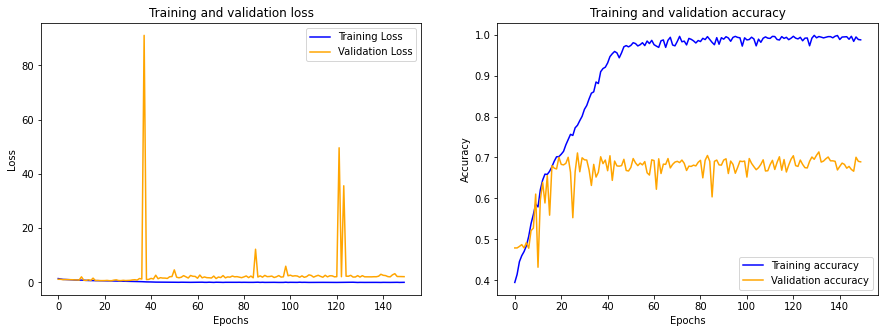

In [16]:
history_dict = hist.history

loss_values = history_dict['loss']
acc_values = history_dict['accuracy']
if split_val:
    val_loss_values = history_dict['val_loss']
    val_acc_values = history_dict['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(loss_values, 'blue', label='Training Loss')
if split_val:
    ax1.plot(val_loss_values, 'orange', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(acc_values, 'blue', label='Training accuracy')
if split_val:
    ax2.plot(val_acc_values, 'orange', label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

In [17]:
loss, accuracy = model.evaluate(x_test, y_test)
print('test loss:', loss)
print('test accuracy:', accuracy)

51/51 [==============================] - 0s 7ms/step - loss: 2.0830 - accuracy: 0.6956
test loss: 2.083035945892334
test accuracy: 0.6955982446670532


# 파일 테스트

In [ ]:
test_file_name = 'dataset/negative/1001_DFA_ANG_XX.wav'

In [ ]:
prediction_feature = extract_feature(test_file_name, input_shape[0]).reshape((1, ) + input_shape)
model = load_model(model_save_path)

predicted_proba = model.predict(prediction_feature)[0]
predicted_class = np.argmax(predicted_proba)

print('classification result:', le.classes_[predicted_class])